In [73]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Creates a new padded version of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)
        
    # Creates a new padded version of each data array with the mean of that array. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_mean(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'mean')
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'mean')
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'mean')
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'mean')

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

In [74]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        timeMs = filenameParts[1]
        numRows = int(filenameParts[2])
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
        
        print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
    # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # preprocess each signal
            x = 0; # no-op just delete this
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [75]:
# Load the data

# You should change the path to the location of the log files on your system
# Showing how to do this on the Mac
# logPath = '/Users/jonf/Dropbox/CSE599_PrototypingInteractive_2019Sp/A03-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\Teaching\MyClasses\CSE599_PrototypingInteractive_2019Sp\Assignments\A3-OfflineGestureRecognizer\Gestures"

# or if you move your gesture logs to the root dir of your Jupyter Notebook, this should work
logPath = '/Users/rashmi/CSE599H/CSE599Sp2019/Assignments/A3-OfflineGestureRecognizer/GestureRecorder/Gestures'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

logPathJon = '/Users/rashmi/CSE599H/CSE599Sp2019/Assignments/A3-OfflineGestureRecognizer/GestureRecognizer/JonGestureLogs'

mapGestureToTrialsJon = parse_and_create_gesture_trials(logPathJon)

Found 55 csv files in /Users/rashmi/CSE599H/CSE599Sp2019/Assignments/A3-OfflineGestureRecognizer/GestureRecorder/Gestures
gestureName=Underhand Bowling timeMs=1557764701530 numRows=189
gestureName=Midair Clockwise 'O' timeMs=1557764827387 numRows=246
gestureName=Forehand Tennis timeMs=1557764682797 numRows=208
gestureName=Midair 'S' timeMs=1557765020500 numRows=227
gestureName=Midair 'S' timeMs=1557765041322 numRows=231
gestureName=Midair Clockwise 'O' timeMs=1557764818079 numRows=229
gestureName=Shake timeMs=1557765063698 numRows=149
gestureName=Midair Counter-clockwise 'O' timeMs=1557764923945 numRows=224
gestureName=Forehand Tennis timeMs=1557764674478 numRows=222
gestureName=Backhand Tennis timeMs=1557764634062 numRows=198
gestureName=Midair 'S' timeMs=1557765031322 numRows=204
gestureName=Baseball Throw timeMs=1557764749226 numRows=215
gestureName=Midair Zorro 'Z' timeMs=1557764971671 numRows=247
gestureName=Backhand Tennis timeMs=1557764613580 numRows=237
gestureName=Shake timeMs

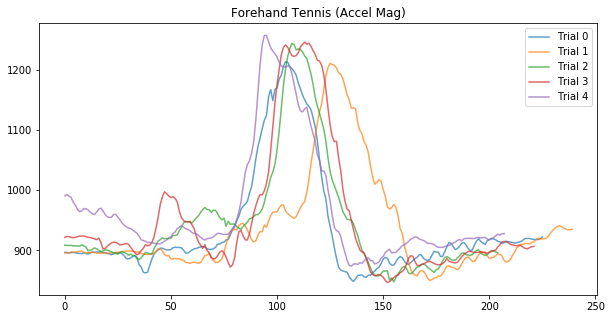

In [76]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


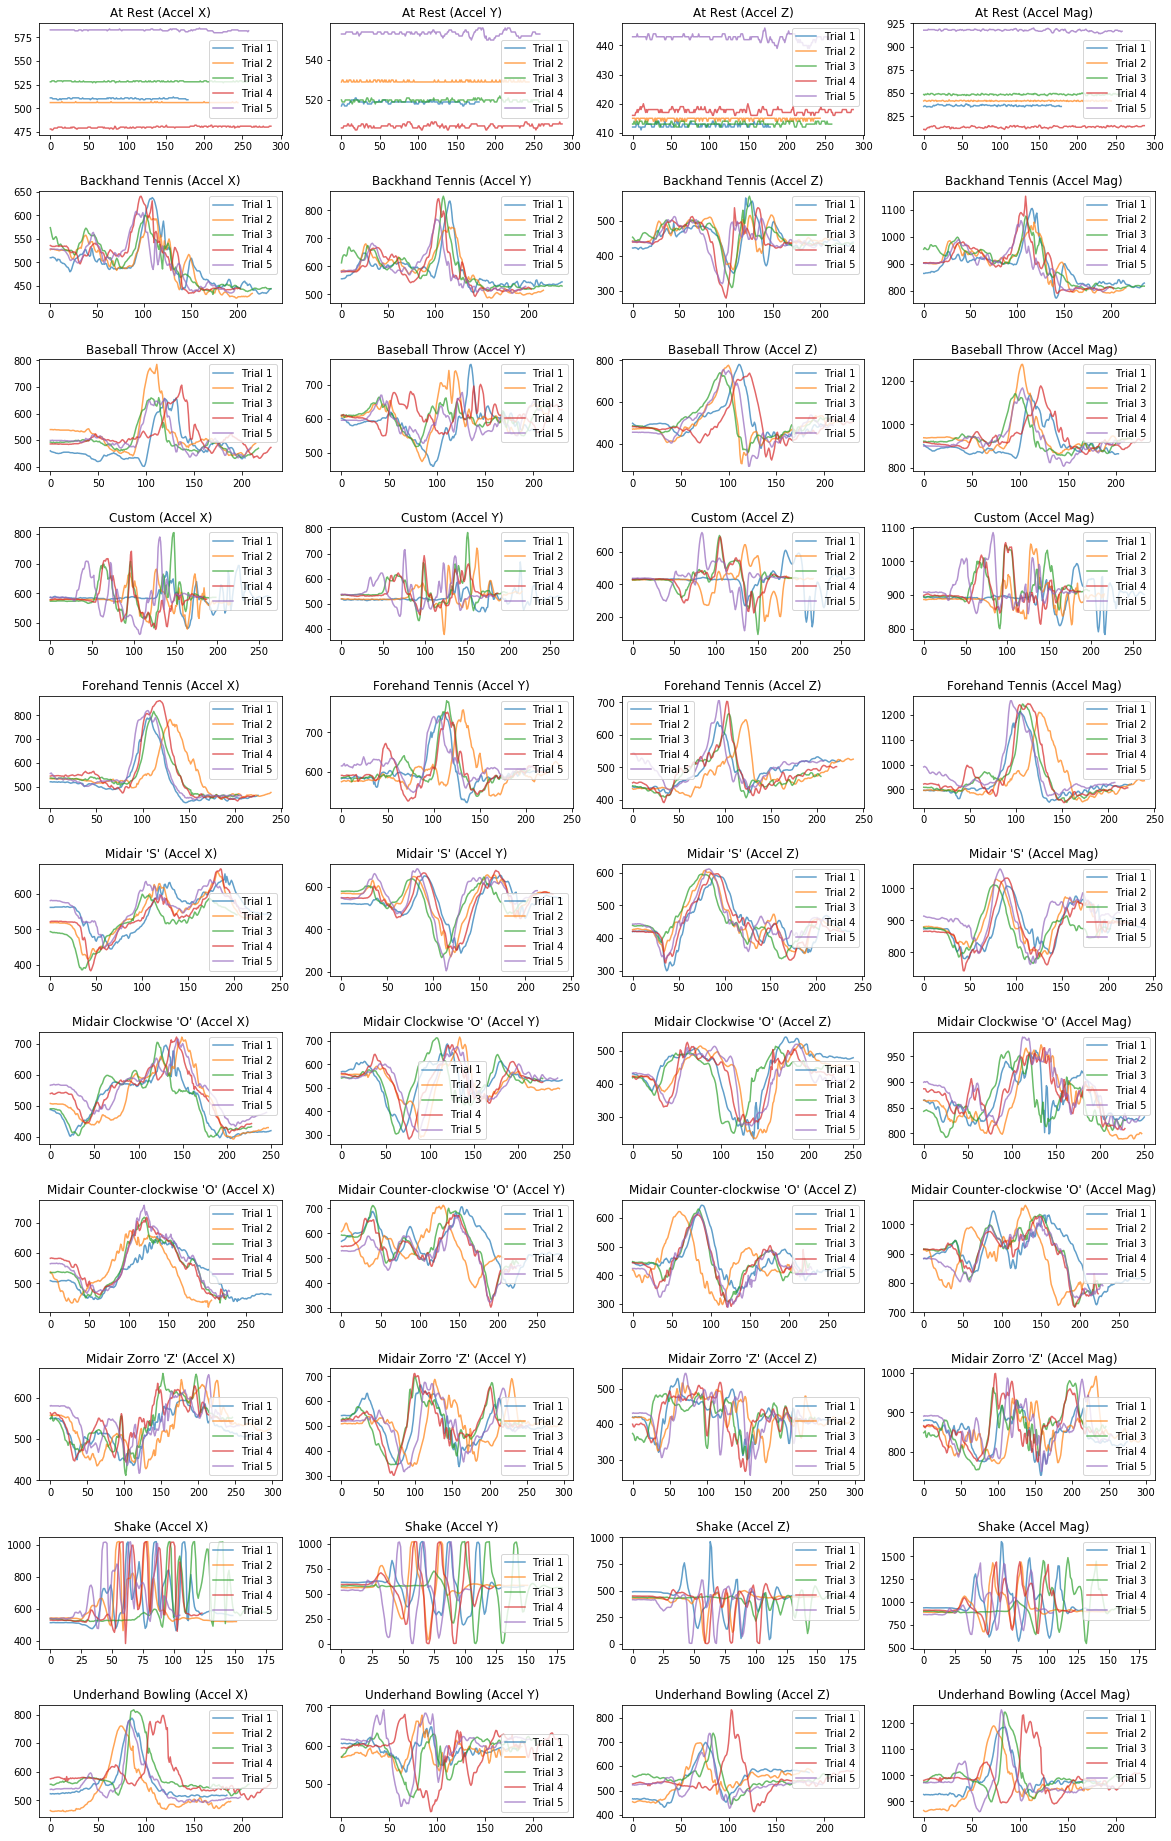

In [77]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1
    
# Jon's gestures
# fig, axes = plt.subplots(len(mapGestureToTrialsJon), 4, figsize=(20, 3 * len(mapGestureToTrialsJon)))
# fig.subplots_adjust(hspace=0.5)

# index = 0
# gestureNamesSorted = sorted(mapGestureToTrialsJon.keys())
# for gestureName in gestureNamesSorted:
#     gestureTrials = mapGestureToTrialsJon[gestureName]
    
#     trialNum = 1
#     for trial in gestureTrials:
#         axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
#         axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
#         axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
#         axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
#         trialNum = trialNum + 1
        
#     axes[index][0].set_title(gestureName + " (Accel X)")
#     axes[index][0].legend()
    
#     axes[index][1].set_title(gestureName + " (Accel Y)")
#     axes[index][1].legend()
    
#     axes[index][2].set_title(gestureName + " (Accel Z)")
#     axes[index][2].legend()
    
#     axes[index][3].set_title(gestureName + " (Accel Mag)")
#     axes[index][3].legend()
#     index = index + 1


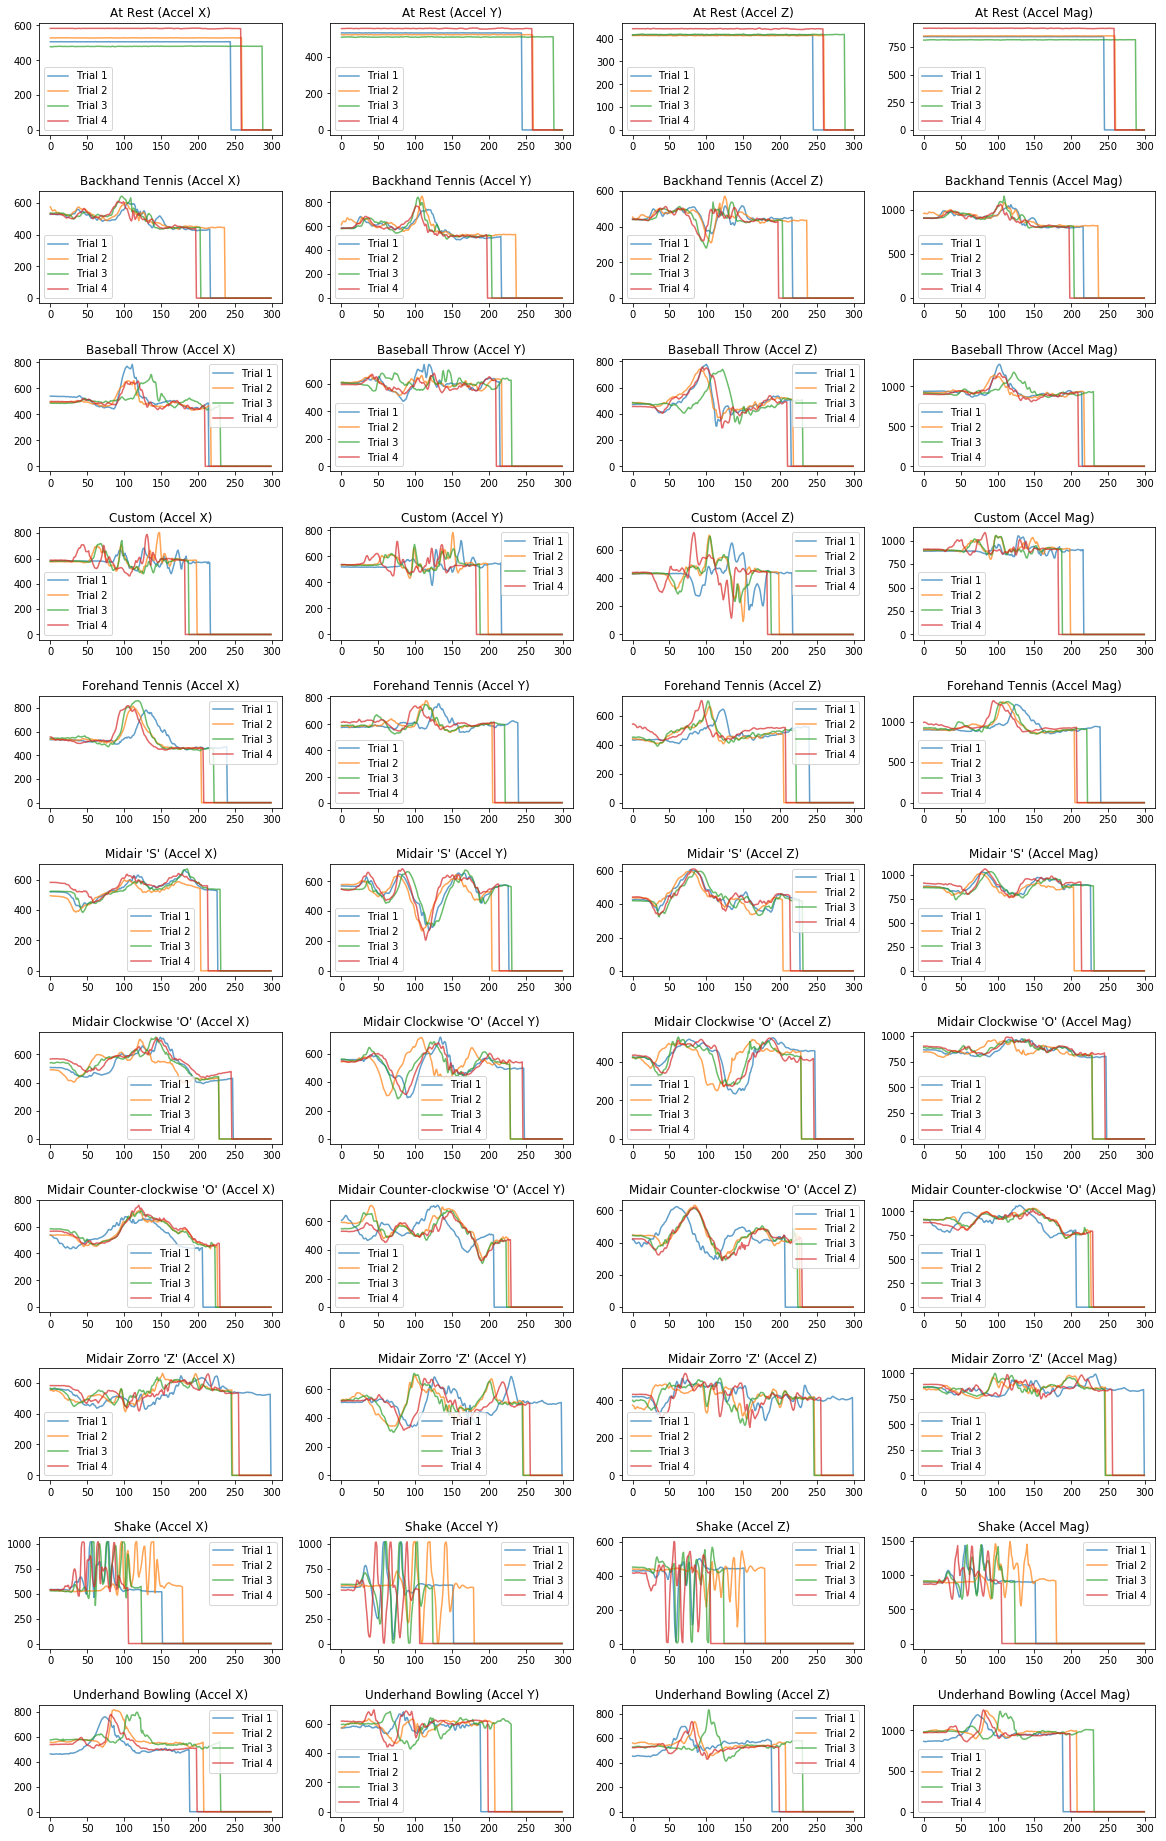

In [95]:
# Splitting into training and testing fold

mapTestGesture = dict()
mapTrainingGesture = dict()

for gestureName in mapGestureToTrials.keys():
    gestureTrials = mapGestureToTrials[gestureName]
    mapGestureToTrials[gestureName][0].accel.pad_with_zeros(300)
    mapTestGesture[gestureName] = mapGestureToTrials[gestureName][0]
    mapTrainingGesture[gestureName] = list()
    trialNum = 0
    for trial in gestureTrials:
        if trialNum != 0:
            mapGestureToTrials[gestureName][trialNum].accel.pad_with_zeros(300)
            mapTrainingGesture[gestureName].append(mapGestureToTrials[gestureName][trialNum])
        trialNum = trialNum + 1
        
#Plot training set (padded)
fig, axes = plt.subplots(len(mapTrainingGesture), 4, figsize=(20, 3 * len(mapTrainingGesture)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapTrainingGesture.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapTrainingGesture[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x_padded, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y_padded, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z_padded, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag_padded, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

In [148]:
#Euclidean distance

from scipy import signal
from scipy.spatial import distance

mapGestureToScore = dict()

for testGestureName in mapTestGesture.keys():
    mapGestureToScore[testGestureName] = dict()
    testAccelData = mapTestGesture[testGestureName]
    
    for trainingGestureName in mapTrainingGesture:
        trainingAccelDataList = mapTrainingGesture[trainingGestureName]
        for trainingAccelData in trainingAccelDataList:
            testAccelData_x = testAccelData.accel.x_padded
            trainingAccelData_x = trainingAccelData.accel.x_padded
            euclid_distance_x = distance.euclidean(testAccelData_x, trainingAccelData_x)
            
            testAccelData_y = testAccelData.accel.y_padded
            trainingAccelData_y = trainingAccelData.accel.y_padded
            euclid_distance_y = distance.euclidean(testAccelData_y, trainingAccelData_y)
            
            testAccelData_z = testAccelData.accel.z_padded
            trainingAccelData_z = trainingAccelData.accel.z_padded
            euclid_distance_z = distance.euclidean(testAccelData_z, trainingAccelData_z)
            
            score = euclid_distance_x + euclid_distance_y + euclid_distance_z
            mapGestureToScore[testGestureName][score] = trainingGestureName
            
for testGestureName in mapGestureToScore:
    print("test gesture:" + testGestureName)
    gestureScore = mapGestureToScore[testGestureName]
    sortedScores = sorted(gestureScore.keys())
    keyIndex = 0
    for score in sortedScores:
        if keyIndex == 0:
            print(score)
            print(gestureScore[score])
            keyIndex = keyIndex + 1
    

test gesture:Underhand Bowling
3793.9943825641967
Underhand Bowling
test gesture:Midair Clockwise 'O'
4371.989491079663
Midair Clockwise 'O'
test gesture:Forehand Tennis
3846.6587230059763
Forehand Tennis
test gesture:Midair 'S'
4529.524826411203
At Rest
test gesture:Shake
7875.937156204478
Shake
test gesture:Midair Counter-clockwise 'O'
5128.3564803808795
At Rest
test gesture:Backhand Tennis
1533.7051012694274
Backhand Tennis
test gesture:Baseball Throw
3851.2885312544395
Forehand Tennis
test gesture:Midair Zorro 'Z'
5754.4404032992115
At Rest
test gesture:At Rest
4374.717300139232
Custom
test gesture:Custom
4507.553275354864
At Rest


In [149]:
#Dynamic time warping

import sys
!{sys.executable} -m pip install fastdtw

from scipy import signal
from scipy.spatial import distance
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

mapGestureToScore = dict()

for testGestureName in mapTestGesture.keys():
    mapGestureToScore[testGestureName] = dict()
    testAccelData = mapTestGesture[testGestureName]
    for trainingGestureName in mapTrainingGesture:
        trainingAccelDataList = mapTrainingGesture[trainingGestureName]
        for trainingAccelData in trainingAccelDataList:
            testAccelData_x = testAccelData.accel.x_padded
            trainingAccelData_x = trainingAccelData.accel.x_padded    
            dist_x, path = fastdtw(testAccelData_x, trainingAccelData_x, dist=euclidean)
            
            testAccelData_y = testAccelData.accel.y_padded
            trainingAccelData_y = trainingAccelData.accel.y_padded
            dist_y, path = fastdtw(testAccelData_y, trainingAccelData_y, dist=euclidean)
            
            testAccelData_z = testAccelData.accel.z_padded
            trainingAccelData_z = trainingAccelData.accel.z_padded
            dist_z, path = fastdtw(testAccelData_z, trainingAccelData_z, dist=euclidean)
            
            score = dist_x + dist_y + dist_z
            mapGestureToScore[testGestureName][score] = trainingGestureName
            
for testGestureName in mapGestureToScore:
    print("test gesture:" + testGestureName)
    gestureScore = mapGestureToScore[testGestureName]
    sortedScores = sorted(gestureScore.keys())
    keyIndex = 0
    for score in sortedScores:
        if keyIndex == 0:
            print(score)
            print(gestureScore[score])
            keyIndex = keyIndex + 1


test gesture:Underhand Bowling
8262.0
Underhand Bowling
test gesture:Midair Clockwise 'O'
7202.0
Midair Clockwise 'O'
test gesture:Forehand Tennis
4393.0
Forehand Tennis
test gesture:Midair 'S'
7474.0
Midair 'S'
test gesture:Shake
21088.0
Shake
test gesture:Midair Counter-clockwise 'O'
6743.0
Midair Counter-clockwise 'O'
test gesture:Backhand Tennis
7818.0
Backhand Tennis
test gesture:Baseball Throw
11461.0
Baseball Throw
test gesture:Midair Zorro 'Z'
10121.0
Midair Zorro 'Z'
test gesture:At Rest
3792.0
At Rest
test gesture:Custom
8234.0
Custom


In [151]:
# Cross Validation

import sys
!{sys.executable} -m pip install fastdtw

from scipy import signal
from scipy.spatial import distance
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Split into training and test set

fold = 0
while fold < 5:
    print(fold)
    mapTestGesture = dict()
    mapTrainingGesture = dict()

    for gestureName in mapGestureToTrials.keys():
        gestureTrials = mapGestureToTrials[gestureName]
        mapGestureToTrials[gestureName][fold].accel.pad_with_zeros(300)
        mapTestGesture[gestureName] = mapGestureToTrials[gestureName][fold]
        mapTrainingGesture[gestureName] = list()
        trialNum = 0
        for trial in gestureTrials:
            if trialNum != fold:
                mapGestureToTrials[gestureName][trialNum].accel.pad_with_zeros(300)
                mapTrainingGesture[gestureName].append(mapGestureToTrials[gestureName][trialNum])
            trialNum = trialNum + 1


    #Dynamic Warping

    mapGestureToScore = dict()

    for testGestureName in mapTestGesture.keys():
        mapGestureToScore[testGestureName] = dict()
        testAccelData = mapTestGesture[testGestureName]
        for trainingGestureName in mapTrainingGesture:
            trainingAccelDataList = mapTrainingGesture[trainingGestureName]
            for trainingAccelData in trainingAccelDataList:
                testAccelData_x = testAccelData.accel.x_padded
                trainingAccelData_x = trainingAccelData.accel.x_padded    
                dist_x, path = fastdtw(testAccelData_x, trainingAccelData_x, dist=euclidean)
            
                testAccelData_y = testAccelData.accel.y_padded
                trainingAccelData_y = trainingAccelData.accel.y_padded
                dist_y, path = fastdtw(testAccelData_y, trainingAccelData_y, dist=euclidean)
            
                testAccelData_z = testAccelData.accel.z_padded
                trainingAccelData_z = trainingAccelData.accel.z_padded
                dist_z, path = fastdtw(testAccelData_z, trainingAccelData_z, dist=euclidean)
            
                score = dist_x + dist_y + dist_z
                mapGestureToScore[testGestureName][score] = trainingGestureName
            
    for testGestureName in mapGestureToScore:
        print("test gesture:" + testGestureName)
        gestureScore = mapGestureToScore[testGestureName]
        sortedScores = sorted(gestureScore.keys())
        keyIndex = 0
        for score in sortedScores:
            if keyIndex == 0:
                print(score)
                print(gestureScore[score])
                keyIndex = keyIndex + 1
    fold = fold + 1

0
test gesture:Underhand Bowling
8262.0
Underhand Bowling
test gesture:Midair Clockwise 'O'
7202.0
Midair Clockwise 'O'
test gesture:Forehand Tennis
4393.0
Forehand Tennis
test gesture:Midair 'S'
7474.0
Midair 'S'
test gesture:Shake
21088.0
Shake
test gesture:Midair Counter-clockwise 'O'
6743.0
Midair Counter-clockwise 'O'
test gesture:Backhand Tennis
7818.0
Backhand Tennis
test gesture:Baseball Throw
11461.0
Baseball Throw
test gesture:Midair Zorro 'Z'
10121.0
Midair Zorro 'Z'
test gesture:At Rest
3792.0
At Rest
test gesture:Custom
8234.0
Custom
1
test gesture:Underhand Bowling
8241.0
Underhand Bowling
test gesture:Midair Clockwise 'O'
6869.0
Midair Clockwise 'O'
test gesture:Forehand Tennis
4430.0
Forehand Tennis
test gesture:Midair 'S'
4920.0
Midair 'S'
test gesture:Shake
20266.0
Shake
test gesture:Midair Counter-clockwise 'O'
6028.0
Midair Counter-clockwise 'O'
test gesture:Backhand Tennis
4660.0
Backhand Tennis
test gesture:Baseball Throw
9701.0
Baseball Throw
test gesture:Midair 

In [197]:
# Random Cross Validation
import random
import sys
!{sys.executable} -m pip install fastdtw

from scipy import signal
from scipy.spatial import distance
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#Map of already tested gesture trials
mapGestureToTestedTrials = dict()

for gestureName in mapGestureToTrials.keys():
    mapGestureToTestedTrials[gestureName] = list()

true_label = list()
predicted_label = list()

# Split into training and test set

mapGestureAccuracy = dict()
for gestureName in mapGestureToTrials.keys():
        mapGestureAccuracy[gestureName] = 0

overall_accuracy = 0
fold = 0
while fold < 5:
    mapTestGesture = dict()
    mapTrainingGesture = dict()

    for gestureName in mapGestureToTrials.keys():
        randTrial = random.randint(0,4)
        while randTrial in mapGestureToTestedTrials[gestureName]:
            randTrial = random.randint(0,4)
        mapGestureToTestedTrials[gestureName].append(randTrial)
        
        gestureTrials = mapGestureToTrials[gestureName]
        mapGestureToTrials[gestureName][randTrial].accel.pad_with_zeros(300)
        mapTestGesture[gestureName] = mapGestureToTrials[gestureName][randTrial]
        mapTrainingGesture[gestureName] = list()
        trialNum = 0
        for trial in gestureTrials:
            if trialNum != randTrial:
                mapGestureToTrials[gestureName][trialNum].accel.pad_with_zeros(300)
                mapTrainingGesture[gestureName].append(mapGestureToTrials[gestureName][trialNum])
            trialNum = trialNum + 1


    #Dynamic Time Warping

    mapGestureToScore = dict()

    for testGestureName in mapTestGesture.keys():
        mapGestureToScore[testGestureName] = dict()
        testAccelData = mapTestGesture[testGestureName]
        for trainingGestureName in mapTrainingGesture:
            trainingAccelDataList = mapTrainingGesture[trainingGestureName]
            for trainingAccelData in trainingAccelDataList:
                testAccelData_x = testAccelData.accel.x_padded
                trainingAccelData_x = trainingAccelData.accel.x_padded    
                dist_x, path = fastdtw(testAccelData_x, trainingAccelData_x, dist=euclidean)
            
                testAccelData_y = testAccelData.accel.y_padded
                trainingAccelData_y = trainingAccelData.accel.y_padded
                dist_y, path = fastdtw(testAccelData_y, trainingAccelData_y, dist=euclidean)
            
                testAccelData_z = testAccelData.accel.z_padded
                trainingAccelData_z = trainingAccelData.accel.z_padded
                dist_z, path = fastdtw(testAccelData_z, trainingAccelData_z, dist=euclidean)
            
                score = dist_x + dist_y + dist_z
                mapGestureToScore[testGestureName][score] = trainingGestureName
    
    print("Fold number:")
    print(fold)
    
    for testGestureName in mapGestureToScore:
        true_label.append(testGestureName)
        
        print("test gesture:" + testGestureName)
        gestureScore = mapGestureToScore[testGestureName]
        sortedScores = sorted(gestureScore.keys())
        keyIndex = 0
        for score in sortedScores:
            if keyIndex == 0:
                
                predicted_label.append(gestureScore[score])
                
                print("Matched gesture: " + gestureScore[score])
                print("score:")
                print(score)
                
                if testGestureName == gestureScore[score]:
                    overall_accuracy = overall_accuracy + 1
                    mapGestureAccuracy[testGestureName] = mapGestureAccuracy[testGestureName] + 1
                
                keyIndex = keyIndex + 1
    
    fold = fold + 1
print("Overall accuracy:")
print(overall_accuracy/55)

print("Accuracy per gesture:")
for gesture in mapGestureAccuracy:
    print("Gesture: " + gesture)
    print("Accuracy:")
    print(mapGestureAccuracy[gesture]/5)



Fold number:
0
test gesture:Underhand Bowling
Matched gesture: Underhand Bowling
score:
8262.0
test gesture:Midair Clockwise 'O'
Matched gesture: Midair Clockwise 'O'
score:
6837.0
test gesture:Forehand Tennis
Matched gesture: Forehand Tennis
score:
4430.0
test gesture:Midair 'S'
Matched gesture: Midair 'S'
score:
7959.0
test gesture:Shake
Matched gesture: Shake
score:
20266.0
test gesture:Midair Counter-clockwise 'O'
Matched gesture: Midair Counter-clockwise 'O'
score:
6209.0
test gesture:Backhand Tennis
Matched gesture: Backhand Tennis
score:
4499.0
test gesture:Baseball Throw
Matched gesture: Baseball Throw
score:
6284.0
test gesture:Midair Zorro 'Z'
Matched gesture: Midair Zorro 'Z'
score:
7828.0
test gesture:At Rest
Matched gesture: Custom
score:
24121.0
test gesture:Custom
Matched gesture: Custom
score:
5644.0
Fold number:
1
test gesture:Underhand Bowling
Matched gesture: Underhand Bowling
score:
7400.0
test gesture:Midair Clockwise 'O'
Matched gesture: Midair Clockwise 'O'
score

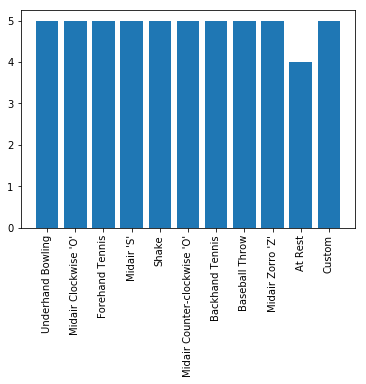

In [167]:
# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary/16014873#16014873

import matplotlib.pyplot as plt

plt.bar(range(len(mapGestureAccuracy)), list(mapGestureAccuracy.values()/5), align='center')
plt.xticks(range(len(mapGestureAccuracy)), list(mapGestureAccuracy.keys()), rotation=90)

plt.show()

['Underhand Bowling', "Midair Clockwise 'O'", 'Forehand Tennis', "Midair 'S'", 'Shake', "Midair Counter-clockwise 'O'", 'Backhand Tennis', 'Baseball Throw', "Midair Zorro 'Z'", 'At Rest', 'Custom']
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 4 1]
 [0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0

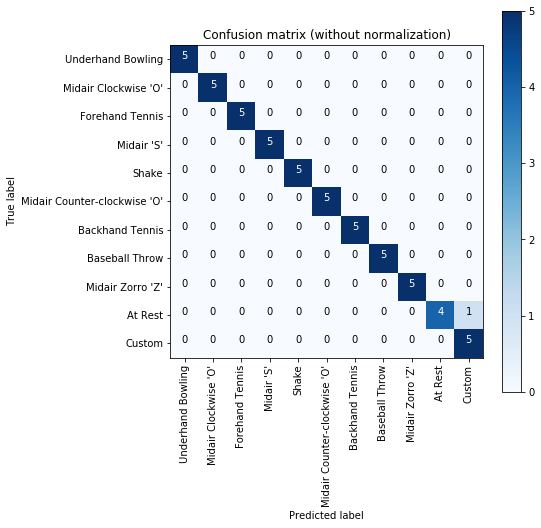

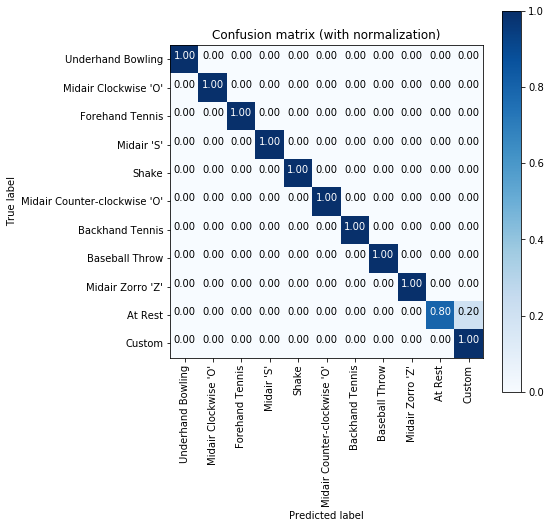

In [191]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = true_label
y_pred = predicted_label
labels = list()
for key in mapGestureToTrials.keys():
    labels.append(key)
print(labels)

cm = confusion_matrix(y_true, y_pred, labels)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

In [193]:
# Random 5 fold cross validation for Jon's data:

import random
import sys
!{sys.executable} -m pip install fastdtw

from scipy import signal
from scipy.spatial import distance
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#Map of already tested gesture trials
mapGestureToTestedTrials = dict()
for gestureName in mapGestureToTrialsJon.keys():
    mapGestureToTestedTrials[gestureName] = list()

true_labelJon = list()
predicted_labelJon = list()

# Split into training and test set
mapGestureAccuracyJon = dict()
for gestureName in mapGestureToTrialsJon.keys():
        mapGestureAccuracyJon[gestureName] = 0

overall_accuracy = 0
fold = 0
while fold < 5:
    mapTestGesture = dict()
    mapTrainingGesture = dict()

    for gestureName in mapGestureToTrialsJon.keys():
        randTrial = random.randint(0,4)
        while randTrial in mapGestureToTestedTrials[gestureName]:
            randTrial = random.randint(0,4)
        mapGestureToTestedTrials[gestureName].append(randTrial)
        
        gestureTrials = mapGestureToTrialsJon[gestureName]
        mapGestureToTrialsJon[gestureName][randTrial].accel.pad_with_zeros(500)
        mapTestGesture[gestureName] = mapGestureToTrialsJon[gestureName][randTrial]
        mapTrainingGesture[gestureName] = list()
        trialNum = 0
        for trial in gestureTrials:
            if trialNum != randTrial:
                mapGestureToTrialsJon[gestureName][trialNum].accel.pad_with_zeros(500)
                mapTrainingGesture[gestureName].append(mapGestureToTrialsJon[gestureName][trialNum])
            trialNum = trialNum + 1


    #Dynamic Warping

    mapGestureToScore = dict()

    for testGestureName in mapTestGesture.keys():
        mapGestureToScore[testGestureName] = dict()
        testAccelData = mapTestGesture[testGestureName]
        for trainingGestureName in mapTrainingGesture:
            trainingAccelDataList = mapTrainingGesture[trainingGestureName]
            for trainingAccelData in trainingAccelDataList:
                testAccelData_x = testAccelData.accel.x_padded
                trainingAccelData_x = trainingAccelData.accel.x_padded    
                dist_x, path = fastdtw(testAccelData_x, trainingAccelData_x, dist=euclidean)
            
                testAccelData_y = testAccelData.accel.y_padded
                trainingAccelData_y = trainingAccelData.accel.y_padded
                dist_y, path = fastdtw(testAccelData_y, trainingAccelData_y, dist=euclidean)
            
                testAccelData_z = testAccelData.accel.z_padded
                trainingAccelData_z = trainingAccelData.accel.z_padded
                dist_z, path = fastdtw(testAccelData_z, trainingAccelData_z, dist=euclidean)
            
                score = dist_x + dist_y + dist_z
                mapGestureToScore[testGestureName][score] = trainingGestureName
    
    print("Fold number:")
    print(fold)
    
    for testGestureName in mapGestureToScore:
        true_labelJon.append(testGestureName)
        
        print("test gesture:" + testGestureName)
        gestureScore = mapGestureToScore[testGestureName]
        sortedScores = sorted(gestureScore.keys())
        keyIndex = 0
        for score in sortedScores:
            if keyIndex == 0:
                
                predicted_labelJon.append(gestureScore[score])
                
                print("Matched gesture: " + gestureScore[score])
                print("score:")
                print(score)
                
                if testGestureName == gestureScore[score]:
                    overall_accuracy = overall_accuracy + 1
                    mapGestureAccuracyJon[testGestureName] = mapGestureAccuracyJon[testGestureName] + 1
                
                keyIndex = keyIndex + 1
    fold = fold + 1
print("Overall accuracy:")
print(overall_accuracy/55)

print("Accuracy per gesture:")
for gesture in mapGestureAccuracyJon:
    print("Gesture: " + gesture)
    print("Accuracy:")
    print(mapGestureAccuracyJon[gesture]/5)

Fold number:
0
test gesture:Midair Zorro 'Z'
Matched gesture: Midair Zorro 'Z'
score:
5869.0
test gesture:Baseball Throw
Matched gesture: Baseball Throw
score:
10903.0
test gesture:Midair 'S'
Matched gesture: Midair 'S'
score:
4749.0
test gesture:Bunny Hops
Matched gesture: Bunny Hops
score:
8799.0
test gesture:Forehand Tennis
Matched gesture: Forehand Tennis
score:
8150.0
test gesture:Midair Counter-clockwise 'O'
Matched gesture: Midair Counter-clockwise 'O'
score:
5354.0
test gesture:At Rest
Matched gesture: At Rest
score:
540.0
test gesture:Midair Clockwise 'O'
Matched gesture: Midair Clockwise 'O'
score:
5216.0
test gesture:Backhand Tennis
Matched gesture: Backhand Tennis
score:
5672.0
test gesture:Shake
Matched gesture: Shake
score:
28820.0
test gesture:Underhand Bowling
Matched gesture: Underhand Bowling
score:
9258.0
Fold number:
1
test gesture:Midair Zorro 'Z'
Matched gesture: Midair Zorro 'Z'
score:
5698.0
test gesture:Baseball Throw
Matched gesture: Baseball Throw
score:
1253

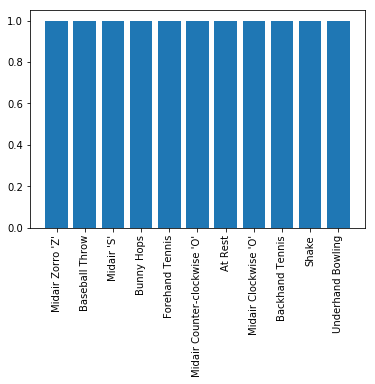

In [194]:
# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary/16014873#16014873

import matplotlib.pyplot as plt

for gesture in mapGestureAccuracyJon.keys():
    mapGestureAccuracyJon[gesture] = mapGestureAccuracyJon[gesture]/5
plt.bar(range(len(mapGestureAccuracyJon)), list(mapGestureAccuracyJon.values()), align='center')
plt.xticks(range(len(mapGestureAccuracyJon)), list(mapGestureAccuracyJon.keys()), rotation=90)

plt.show()

["Midair Zorro 'Z'", 'Baseball Throw', "Midair 'S'", 'Bunny Hops', 'Forehand Tennis', "Midair Counter-clockwise 'O'", 'At Rest', "Midair Clockwise 'O'", 'Backhand Tennis', 'Shake', 'Underhand Bowling']
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


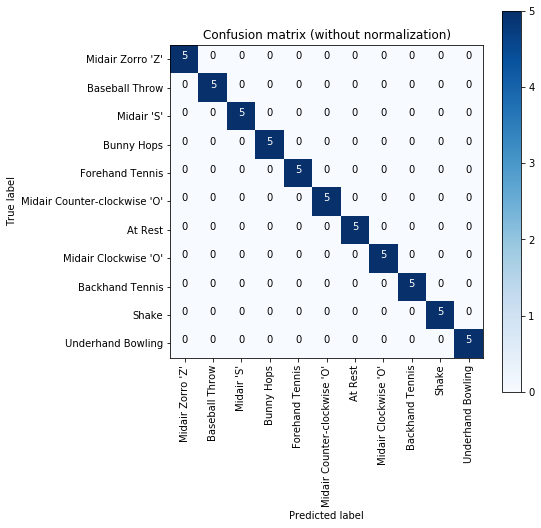

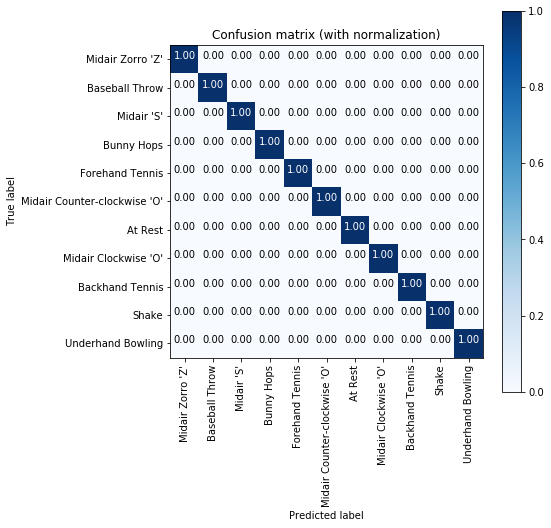

In [195]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = true_labelJon
y_pred = predicted_labelJon
labels = list()
for key in mapGestureToTrialsJon.keys():
    labels.append(key)
print(labels)

cm = confusion_matrix(y_true, y_pred, labels)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()